This notebook is a slightly adapted version from the notebook Chapter 10 - Predicting Continous Target Variables with Regression Analysis from Sebastian Raschka's excellent book "Python Machine Learning".

Below we import the Seaborn module, which is useful to do some preliminary, visually, statistics oriented exploratory data analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We will use the [housing dataset](http://archive.ics.uci.edu/ml/datasets/Housing) as our regression source. De dataset has the following features:
    
<pre>
1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per $10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in $1000's
</pre>

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header = None, sep='\s+')
df.columns = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


MEDV is our target value. In contrast to the discrete, categorical targets, or class targets (values belonging to a restricted set of values) we saw before, MEDV is a continuous target variable. To predict its value we will use a regressor, rather than a classifier. In the scatter plot matrix below we set some feature variables against our target variable. As we want to apply a linear regression model, we are looking for a linear relation between any feature variable and our target variable.

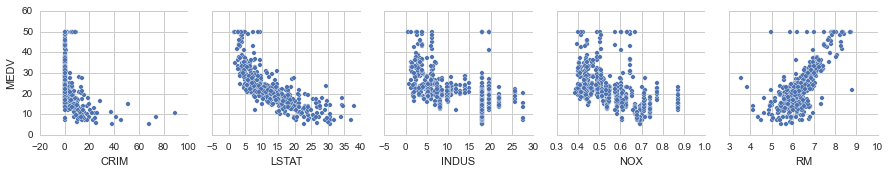

In [3]:
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, x_vars=['CRIM', 'LSTAT', 'INDUS', 'NOX', 'RM'], y_vars=['MEDV'], size=2.5)
plt.show()

From the above scatter plot matrix, we can conclude that the RM feature has the best linear relation with our target variable. LSTAT is also very close but it does not present a straight line relation, so we skip it.

Another way to look at possible strong relationships between any feature variable and our target variable is to look at correlations. We will use the "Pearson product-moment correlation" to analyse a possible correlation. Correlation is a value between -1 and 1. Whereas <b>-1</b> is used for <b>strong negative relation</b>, <b>0</b> for <b>no relation at all</b> and <b>1</b> for a <b>strong positive relation</b>. We will use a heatmap to visualize the correlation. There is a lot of noise in this heatmap. However,  we are only interested in the first 5 cells of the last row as we are only interested in a correlation with our target value.

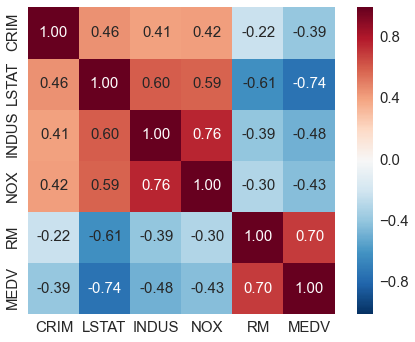

In [4]:
cols = ['CRIM', 'LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
cm = np.corrcoef(df[cols].values, rowvar=0)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15}, yticklabels=cols, xticklabels=cols)
plt.show()

As we can conclude from these plot as well is that we have to strong correlations between our target variable MEDV. LSTAT has a negative value, hence we skip, as we concluded from the scatter plot. RM is the feature we pick to base our linear regression model on.

In [5]:
from sklearn.linear_model import LinearRegression

X = df[['RM']].values
y = df['MEDV'].values

slr = LinearRegression()
slr.fit(X,y)
print('Slope: %.3f' %slr.coef_[0])
print('Intercept: %.3f' %slr.intercept_)

Slope: 9.102
Intercept: -34.671


We found slope and intercept of our regression line equation. Now let's look at how that line relates to our measures in the selected feature variable.

In [6]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return None

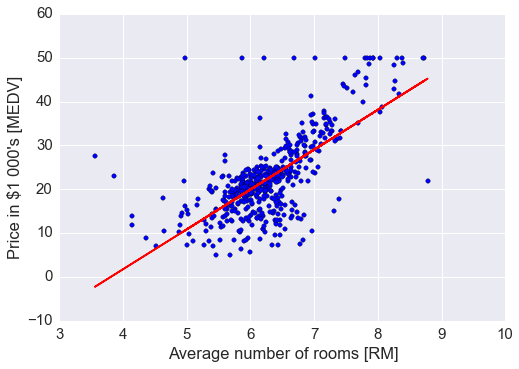

In [7]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1 000\'s [MEDV]')
plt.show()

Linear regression models can be heavily impacted by the presence of outliers. In certain situations, a very small subset of our data can have a big effect on the estimated model coefficients.
There are many statistical techniques to remove outliers from your measures. Instead of using such a technique, we will apply a liner regressor that is less susceptible for outliers: <b>RANdom SAmple Consensus(RANSAC)</b>

Summurizing the RANSAC algorithm:
    - Select random number of samples to be inliers and fit the model
    - Test all other data points againts the fitted model and add those points that fall within a user-given tolerance to the inliers.
    - Refit the model using all inliers.
    - Estimate the error of the fitted model versus the inliers.
    - Terminate the algorithm if the performance meets a certain user-defined threshold or if a fixed number of iterations has been reached.

In [8]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), 
                        max_trials=100,
                        min_samples=50,
                        residual_metric=lambda x: np.sum(np.abs(x), axis=1),
                        residual_threshold=5.0,
                        random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, max_trials=100,
        min_samples=50, random_state=0,
        residual_metric=<function <lambda> at 0x000000000AFB4840>,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

We set the maximum number of iterations of the RANSAC to 'max_trials = 100', then we set the minimum number random selected sample data to 'min_sample = 50'. Using the 'residual_metric' parameter, we provided a callable lambda function that simply calculates the absolute vertical distance between the fitted line and any sample point. By setting 'residual_threshold' parameter to 5.0, we only allowed samples to be included in the inlier set if their vertical distance to the fitted line is within 5 distance units.

After we have fitted the RANSAC model, let's obtain the inliers and outliers from the fitted RANSAC linear regression model and plot them together with the linear fit:

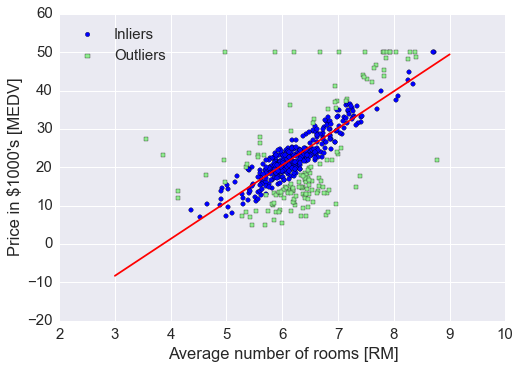

In [9]:
inlier_mask = ransac.inlier_mask_
# inliers = !outliers
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3,10, 1)
line_y_ransac = ransac.predict(line_X[:,np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()

Let's see check the slope and the intercept to see if they have changed after applying the RANsac

In [10]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_[0])

Slope: 9.621
Intercept: -37.137


Numbers have changed but we don't know whether it has a positive effect on the predictive performance for unseen data. Thus, in the next section we will discuss how to evaluate a regression model for different approaches.

Now we will use all the variables in the dataset and train a multiple regression model.

In [11]:
from sklearn.cross_validation import train_test_split

X = df.iloc[:,:-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

Since our model uses multiple explanatory variables, we can't visualize the linear regression line( or hyperplane to be precise) in two dimensional plot, but we can plot the residuals (the vertical distances between the actual and predicted values) versus the predicted values to diagnose our regression model.

Those <b>residual plots</b> are a commonly used graphical analysis for diagnosing regression models to detect non linearity and ourliers, and to check if the errors are randomly distributed.

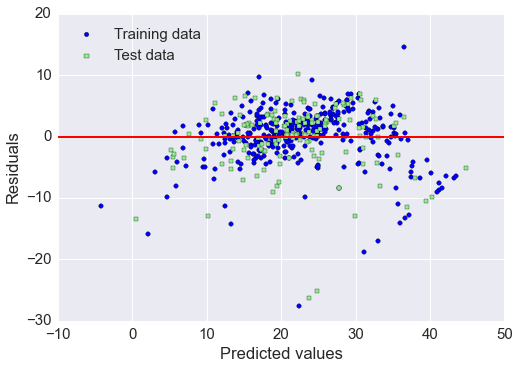

In [12]:
# plotting residual plot, substracting the true target variable from our predicted responses
plt.scatter(y_train_pred, y_train_pred - y_train, c='blue',
           marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen',
           marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()

In case of a perfect prediction, the residuals would be exactly zero, which we will probably never encounter in realistic and practical applications. However, for a good regression model, we would expect that the errors are randomly distributed and the residuals  should be randomly scattered around the centerline. If we see <b>patterns</b> in a residual plot, it means that our model is unable to capture some explanatory information, which is leaked into the residuals as we can slightly see in our preceding residual plot.

Another useful quantitative measure of a model's performance is the so-called <b>Mean Squared Error</b>, MSE, which is simply the average value of the SSE cost function that we minimize to fit the linear regression model. The MSE is useful to for comparing different regression models or for tuning their parameters via a grid search and cross-validation.

In [13]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' %(
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


Sometimes it may be more useful to report the coefficient of determination (<b> R2 </b>), which can be understood as a standardized version of the MSE, for better interpretability of the model performance. In other words, R2 is the fraction of response variance that is captured by the model.

In [14]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                                      r2_score(y_test, y_test_pred)))

R^2 train: 0.765, test: 0.673


<b>1.</b>We only calculated the MSE and R^2 for the standard linear regressor. But let's check both for the RANSAC regressor.

In [15]:
# y_rancas_pred = ransac.predict(X)
# print('MSE: %.3f' % mean_squared_error(y, y_ransac_pred,multioutput='raw_values'))

In [16]:
df = pd.read_csv('data/grades.csv', sep=',')
df.head()

,Grade,Semester,Fun,GroupIndividual,Satisfaction
0,8,1,8,0,8
1,10,1,6,1,10
2,6,2,6,1,7
3,9,1,7,0,8
4,8,2,9,0,7


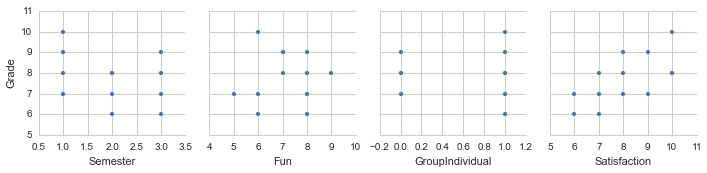

In [17]:
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, x_vars=['Semester','Fun','GroupIndividual', 'Satisfaction'], y_vars=['Grade'], size=2.5);
plt.show()

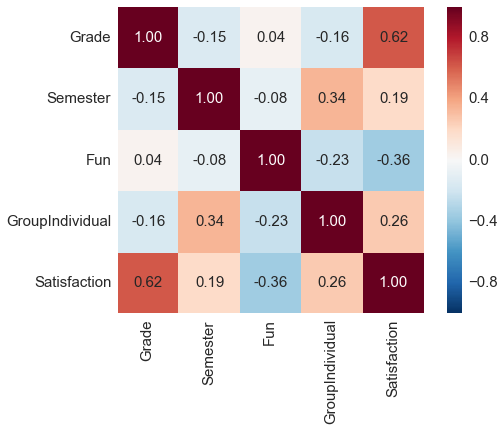

In [18]:
cols = ['Grade', 'Semester', 'Fun', 'GroupIndividual', 'Satisfaction']
cm = np.corrcoef(df[cols].values, rowvar=0)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
    annot_kws={'size': 15},
    yticklabels=cols,
    xticklabels=cols)
plt.show()

In [19]:
from sklearn.linear_model import LinearRegression

X = df[['Fun']].values
y = df['Grade'].values

slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 0.039
Intercept: 7.502


In [20]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')    
    return None

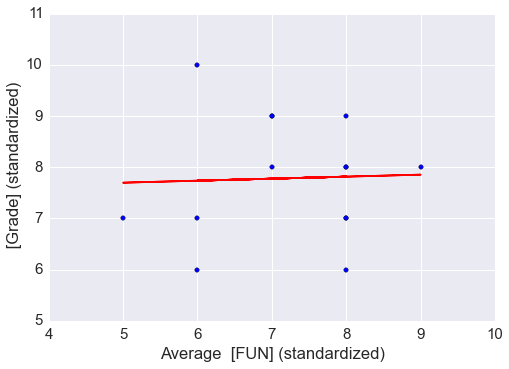

In [21]:
lin_regplot(X, y, slr)
plt.xlabel('Average  [FUN] (standardized)')
plt.ylabel(' [Grade] (standardized)')
plt.show()

In [22]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
    max_trials=100,
    min_samples=10,
    residual_metric=lambda x: np.sum(np.abs(x), axis=1), 
    residual_threshold=5.0, 
    random_state=0)
ransac.fit(X, y)
print("Coeficient of determination on the training set:",ransac.score(X,y))

Coeficient of determination on the training set: 0.00137631046845


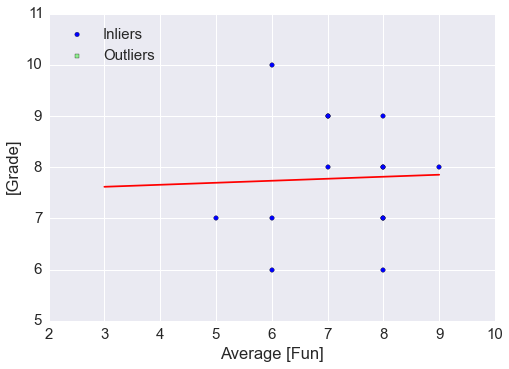

In [23]:
inlier_mask = ransac.inlier_mask_
# outliers = !inliers
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
    c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
    c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average [Fun]')
plt.ylabel('[Grade]')
plt.legend(loc='upper left')
plt.show()

In [24]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 0.039
Intercept: 7.502


In [25]:
from sklearn.cross_validation import train_test_split
X = df.iloc[:, :-1].values
y = df['Fun'].values
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.3, random_state=0
)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

print(y_train_pred)
print(y_test_pred)

[ 8.  6.  6.  7.  8.  7.  8.  8.  8.]
[ 8.  5.  9.  7.  6.]


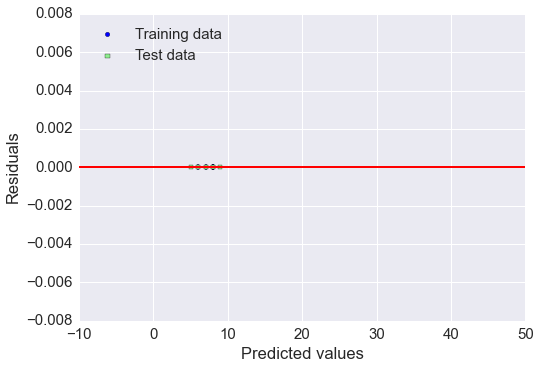

In [26]:
plt.scatter(y_train_pred, y_train_pred - y_train,
    c='blue', marker='o', label='Training data'
)
plt.scatter(y_test_pred,  y_test_pred - y_test,
    c='lightgreen', marker='s', label='Test data'
)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()

In [27]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor()
ransac.fit(X, y)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        max_trials=100, min_samples=None, random_state=None,
        residual_metric=None, residual_threshold=None, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

In [28]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))

MSE train: 0.000, test: 0.000


In [29]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % 
    (r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))  # output is 1, data fits perfectly

R^2 train: 1.000, test: 1.000
